In [1]:
options(repr.plot.width=18, repr.plot.height=12)

suppressMessages(library(tidyverse))
suppressMessages(library(unglue))
theme_set(theme_classic(22))
1 + 1

[1] 2

In [2]:
files <- fs::dir_ls("output/bed/")
unglue_str <- "output/bed/rep-{rep}_seed1-{seed1}_seed2-{seed2}_startfreq-{start_freq}_endfreq-{end_freq}_alpha-{alpha}_sub-{sub}.bed"

#read in interval information for each sim
suppressMessages(
    full_df <- 
    files %>% 
    map_df(~ {
        bed_df <- read_delim(.x, "\t", col_names = c("chrom", "start", "end", "mu"))
        meta_df <- unglue(.x, unglue_str)[[1]] %>% 
            mutate_all(as.numeric)
        bind_cols(bed_df, meta_df)
    }) %>% 
    mutate(
        sweep_type = ifelse(start_freq == 0, "hard", "soft"),
        complete = ifelse(end_freq <= 0.5, "incomplete", "complete")
    )
) 
head(arrange(full_df, rep, sub))


chrom,start,end,mu,rep,seed1,seed2,start_freq,end_freq,alpha,sub,sweep_type,complete
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ch1,83062,374804,21.71,0,42899,43395,0,0.999,0,1,hard,complete
ch1,56547,399407,13.08,0,42899,43395,0,0.999,0,2,hard,complete
ch1,67024,360387,17.00,1,47978,26105,0,0.999,10,1,hard,complete
ch1,82913,247983,20.02,1,47978,26105,0,0.999,10,2,hard,complete
ch1,348707,399248,12.47,1,47978,26105,0,0.999,10,2,hard,complete
ch1,173138,389758,22.38,2,11315,19544,0,0.999,50,1,hard,complete


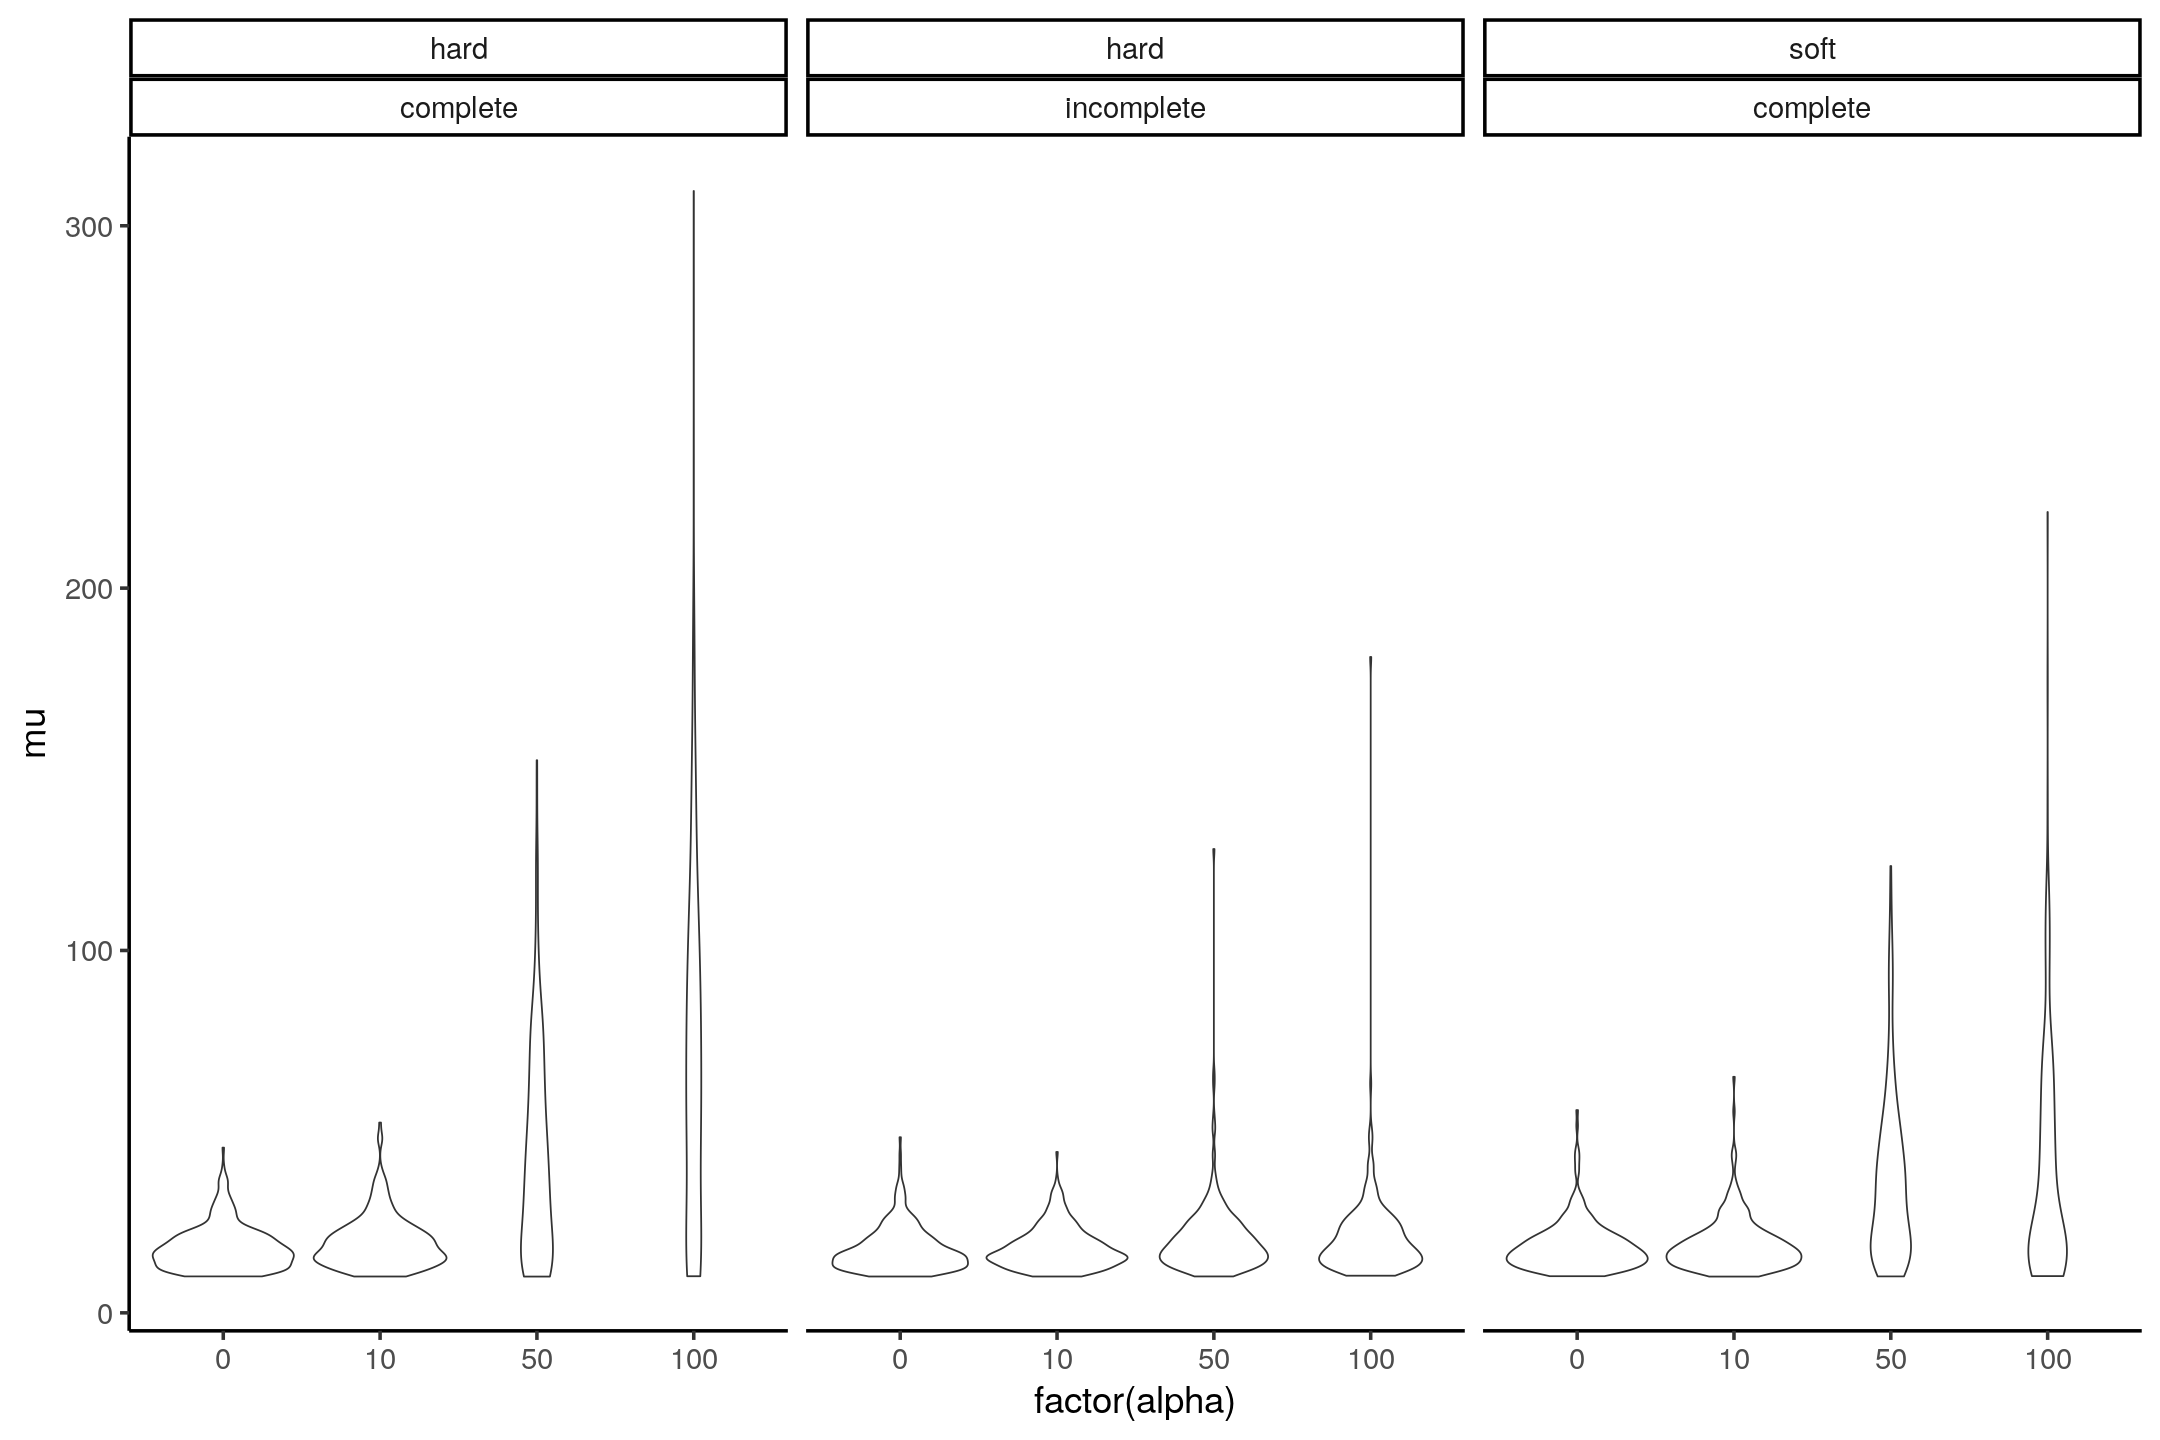

In [3]:
full_df %>% 
    ggplot(aes(factor(alpha), mu)) +
    geom_violin()+
    #geom_jitter(height = 0, width = 0.1) +
    facet_wrap(~sweep_type + complete)

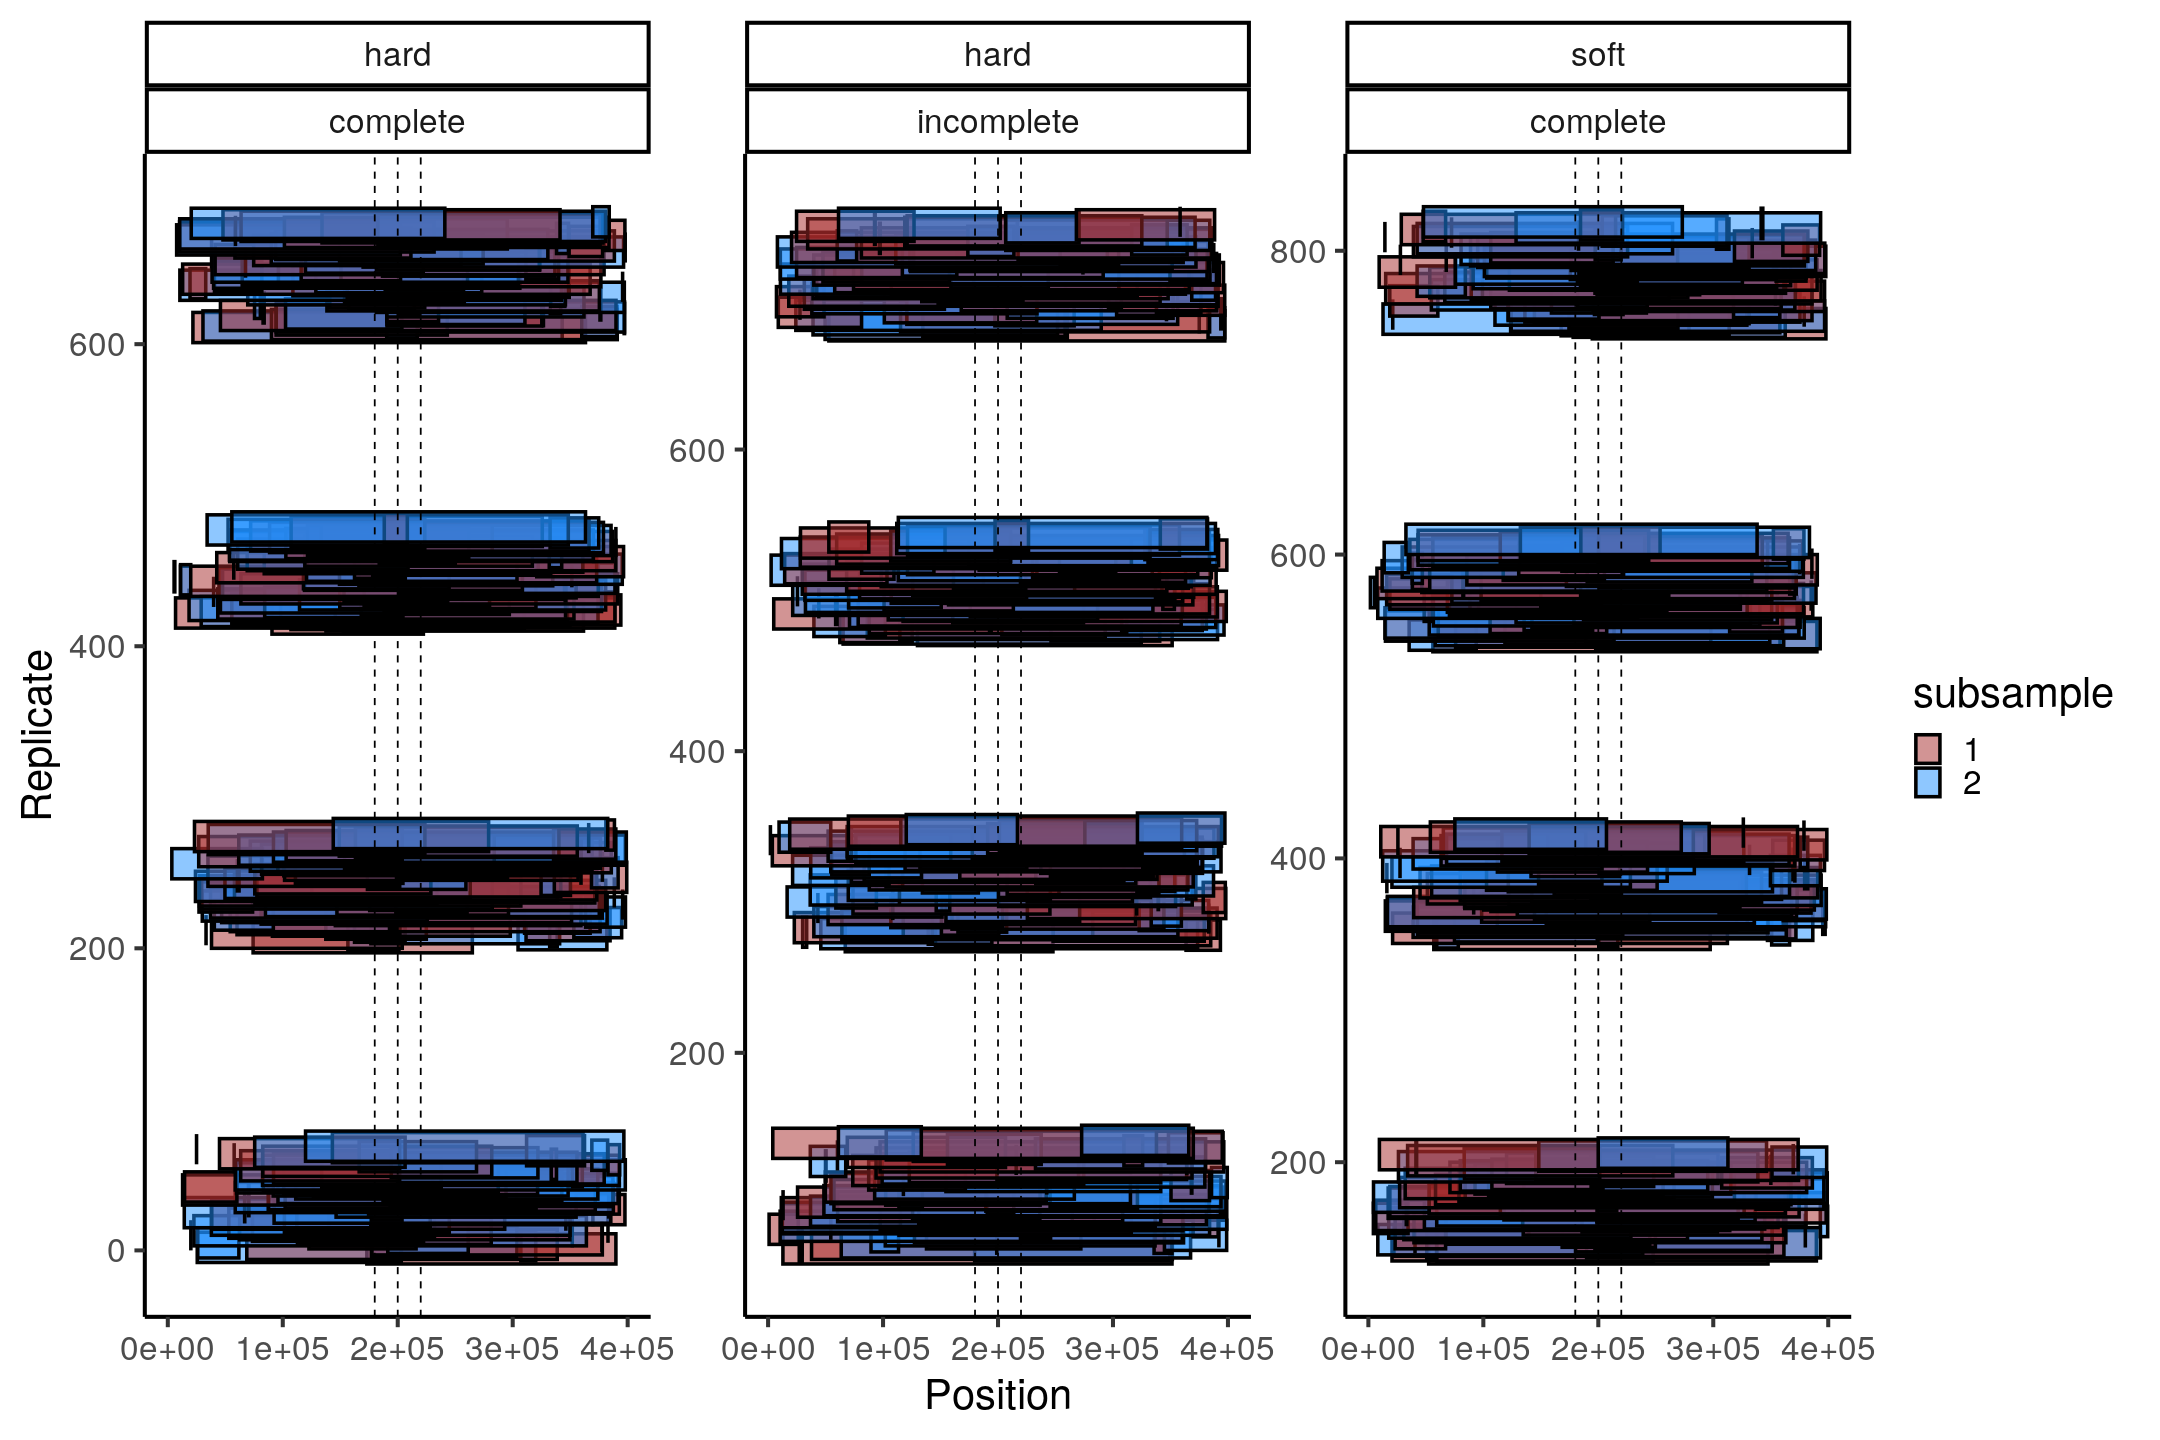

In [4]:
options(repr.plot.width=18, repr.plot.height=12)

near_x  <- 0.1
sweep_pos  <- 200000
rw <- 10
full_df %>%
filter(alpha == 50) %>% 
arrange(rep, sub,sweep_type, complete) %>% 
ungroup() %>% 
mutate(rep = 1:n()) %>% 
    group_by(sweep_type, complete, rep) %>% 
    ggplot() +
    geom_rect(
        aes(xmin=start, ymin = rep-rw, 
            xmax = end, ymax = rep+rw, fill = factor(sub)), 
        colour = "black", lwd = 1, alpha = 0.5) +
    geom_vline(xintercept = sweep_pos, lty = 2) +
    geom_vline(xintercept = sweep_pos*(1+near_x), lty = 2) +
    geom_vline(xintercept = sweep_pos*(1-near_x), lty = 2) +
    facet_wrap(~sweep_type + complete, scales = "free") +
    coord_cartesian(xlim=c(0, 4e5)) +
    guides(fill=guide_legend(title="subsample")) +
    scale_fill_manual(values = c("1" = "brown", "2" = "dodgerblue")) +
    theme_classic(25) +
    xlab("Position") +
    ylab("Replicate") +
    ggsave("../../../figures/supplement_discoal.pdf", width = 18, height = 12)


[1] "in how many sims did both reps overlap with true sweep region?"


`summarise()` has grouped output by 'rep', 'sweep_type', 'complete'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sweep_type', 'complete'. You can override using the `.groups` argument.



sweep_type,complete,alpha,p_overlap,p_near
<chr>,<chr>,<dbl>,<dbl>,<dbl>
hard,complete,0,0.39,0.55
hard,complete,10,0.62,0.81
hard,complete,50,0.95,0.99
hard,complete,100,0.97,1.00
hard,incomplete,0,0.37,0.55
hard,incomplete,10,0.54,0.71
hard,incomplete,50,0.61,0.75
hard,incomplete,100,0.72,0.85
soft,complete,0,0.47,0.63


[1] "how large are sweep regions?"


,alpha,mean_size,sd_size
,<dbl>,<dbl>,<dbl>
1,0,138007.4,115651.5
2,10,149476.3,119049.4
3,50,157296.7,114847.4
4,100,153062.3,112323.4


[1] "how many are there?"


`summarise()` has grouped output by 'rep', 'sweep_type'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sweep_type'. You can override using the `.groups` argument.



sweep_type,complete,min(count),max(count),mean(count)
<chr>,<chr>,<int>,<int>,<dbl>
hard,complete,2,5,3.04
hard,incomplete,2,6,3.12
soft,complete,2,5,2.88


`summarise()` has grouped output by 'sweep_type', 'complete'. You can override using the `.groups` argument.



sweep_type,complete,alpha,n()
<chr>,<chr>,<dbl>,<int>
hard,complete,0,304
hard,complete,10,293
hard,complete,50,272
hard,complete,100,260
hard,incomplete,0,312
hard,incomplete,10,304
hard,incomplete,50,282
hard,incomplete,100,271
soft,complete,0,288


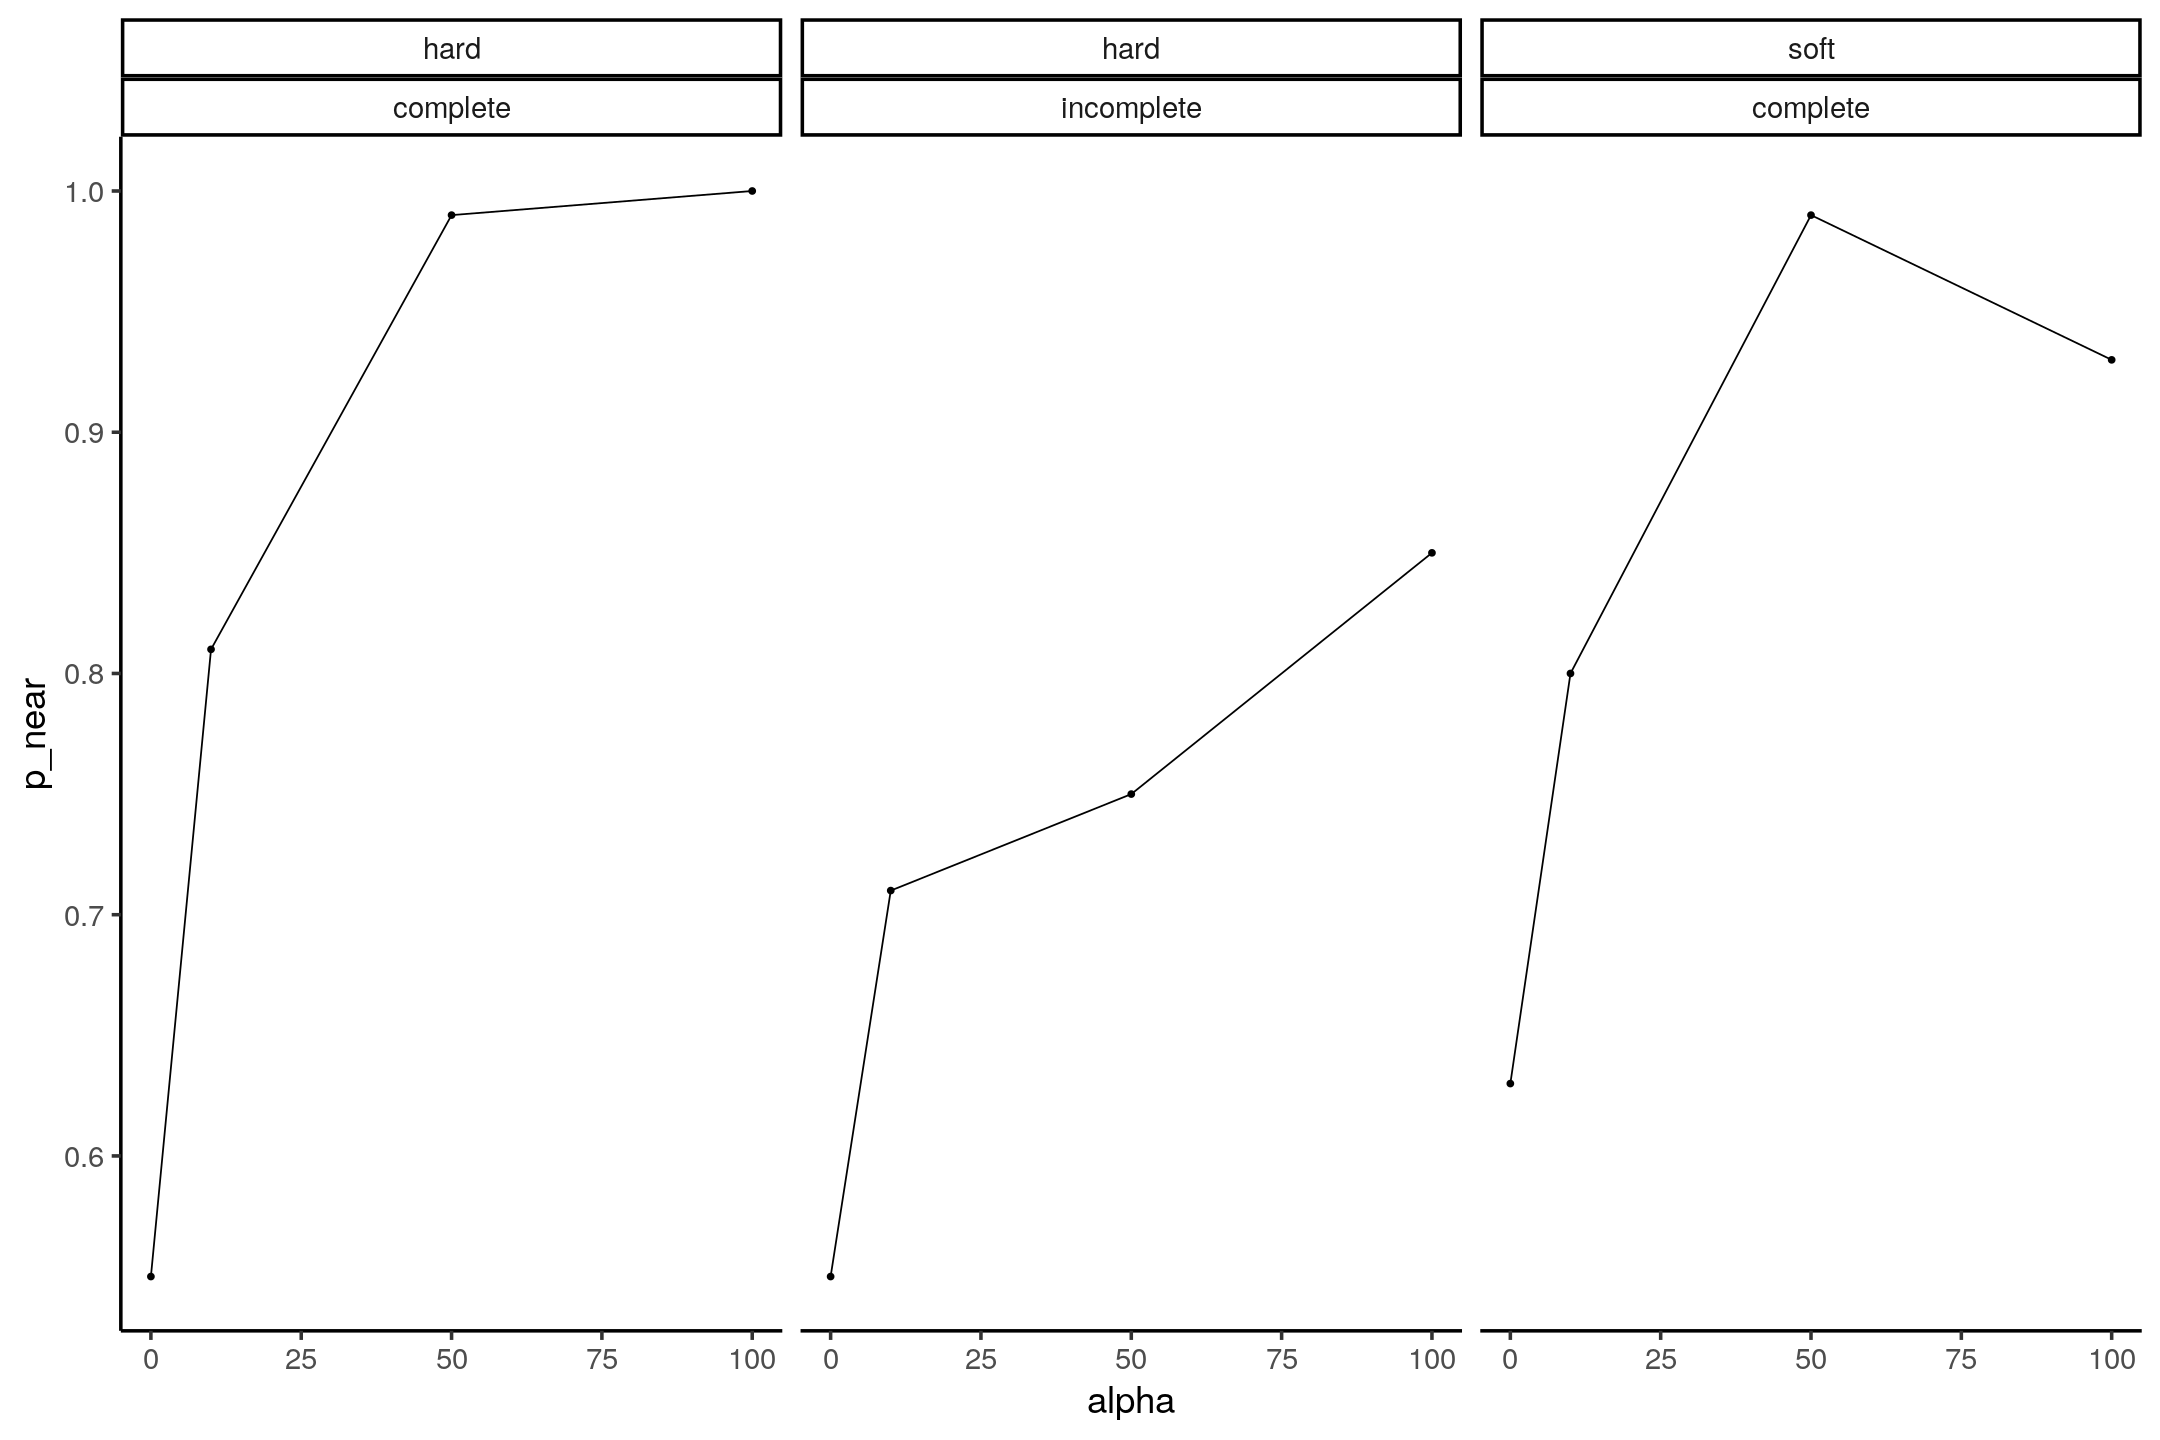

In [5]:
alpha_df <- full_df %>% filter(alpha == 0)

print("in how many sims did both reps overlap with true sweep region?")
overlap_alpha_df <- 
full_df %>% 
    mutate(overlaps_sweep = start < sweep_pos & end >= sweep_pos) %>% 
    mutate(near_sweep = start <= sweep_pos*(1+near_x) & end >= sweep_pos*(1-near_x)) %>% 
    group_by(rep, sweep_type, complete, alpha) %>% 
    summarise(both_at = sum(overlaps_sweep), both_near = sum(near_sweep)) %>% 
    group_by(sweep_type, complete, alpha) %>% 
    summarise(p_overlap = mean(both_at == 2), p_near = mean(both_near == 2))
overlap_alpha_df

overlap_alpha_df %>% 
    ggplot(aes(alpha, p_near)) +
    geom_line() +
    geom_point() +
    facet_wrap(~sweep_type+complete)

print("how large are sweep regions?")
full_df %>% 
    mutate(size = end - start) %>% 
    group_by(alpha) %>% 
    summarise(mean_size = mean(size), sd_size = sd(size))

print("how many are there?")
alpha_df %>% 
    group_by(rep, sweep_type, complete) %>% 
    summarise(count = n()) %>% 
    group_by(sweep_type, complete) %>% 
    summarise(min(count), max(count), mean(count))


full_df %>% 
    group_by(sweep_type, complete, alpha) %>% 
    summarise(n())

In [24]:
mu_sig <- 4
merge_size <- 1e5
sweep_pos  <- 200000
min_sweep_size <- 5e3
max_sweep_size <- 1e5
raisd_files <- fs::dir_ls("output/raisd/", glob = "*RAiSD_Report*alpha-*")

random_files <- sample(raisd_files, 20)
#random_files <- raisd_files
suppressWarnings(
suppressMessages(
confusion_df <- map_df(random_files, function(random_file){
    
    #read data, fit smooth spline model
    rdf <- read_delim(random_file, "\t", skip = 1, col_names = c("pos", "mu"))
    zz_smooth <- smooth.spline(rdf$pos, rdf$mu)
    smooth_df <- bind_cols(x = zz_smooth$x, y = zz_smooth$y)
    
    #block off outliers into sections
    spline_assess <- filter(smooth_df, y > mu_sig) %>% 
        mutate(section = round(x/merge_size))

    #ggplot() +
    #    geom_point(data = filter(rdf, mu > 0), aes(pos, mu), alpha = 0.4) +
    #    geom_line(data = smooth_df, aes(x, y), colour = "blue") +
    #    geom_line(data = spline_assess, aes(x, y, group = section, color = factor(section)), lwd = 2)

    
    #get value of alpha for input
    unglue_str <- "output/raisd/RAiSD_Report.rep-{red}_seed1-{s1}_seed2-{s2}_startfreq-{startfreq}_endfreq-{endfreq}_alpha-{alpha}_sub-{sub}"
    alpha <- as.integer(unglue(random_file, unglue_str)[[1]]$alpha)

    #convert to sweep regions according to postions over which spline is above cutoff and seperate from other regions
    #also declare things outside of size limit to not be a sweep
    state_df <- 
    spline_assess %>%
        mutate(merge_count = length(unique(section))) %>% 
        group_by(section, merge_count) %>%
        summarise(max_y = max(y), start = min(x)-1, end = max(x), size = max(x)-min(x), count = length(x)) %>% 
        mutate(
            alpha = alpha,
            file = random_file,
            sweep = case_when(
                between(size, min_sweep_size, max_sweep_size) ~ "sweep",
                sum(start < sweep_pos & end > sweep_pos) < 1 ~ "noise",
                TRUE ~ "noise"
            )
        )

    #dummy dataframe for when no sweep regions are found
    if (nrow(state_df) == 0){
    state_df <- tibble(
        section = NA,
        merge_count = NA,
        max_y = NA,
        start = ifelse(alpha > 0, sweep_pos-1, -9),
        end = ifelse(alpha > 0, sweep_pos+1, -9),
        size = NA,
        count = NA,
        alpha = alpha,
        sweep = "noise",
        file = random_file
        )
    }
    
        #determine if each classified region is False/True and Positive/Negative
        state_df %>% 
        mutate(
            stat_state = case_when(
                alpha >  0 & between(sweep_pos, start, end) & sweep == "sweep" ~ "TP",
                alpha >  0 & between(sweep_pos, start, end) & sweep == "noise" ~ "FN",
                alpha >  0 & !between(sweep_pos, start, end) & sweep == "sweep" ~ "FP",
                alpha >  0 & !between(sweep_pos, start, end) & sweep == "noise" ~ "TN",             
                alpha == 0 & sweep == "sweep" ~ "FP",
                alpha == 0 & sweep == "noise" ~ "TN",
                TRUE ~ NA_character_
            )
        )
    })
)
)

In [26]:
confusion_df %>% 
    group_by(stat_state) %>% 
    summarise(n())

,stat_state,n()
,<chr>,<int>
1,FN,3
2,FP,2
3,TN,15
4,TP,5


output/raisd/RAiSD_Report.rep-1055_seed1-14967_seed2-56422_startfreq-0.0_endfreq-0.5_alpha-100_sub-2



── Column specification ───────────────────────────────────────────────────────────────────────────────────
cols(
  pos = col_double(),
  mu = col_double()
)




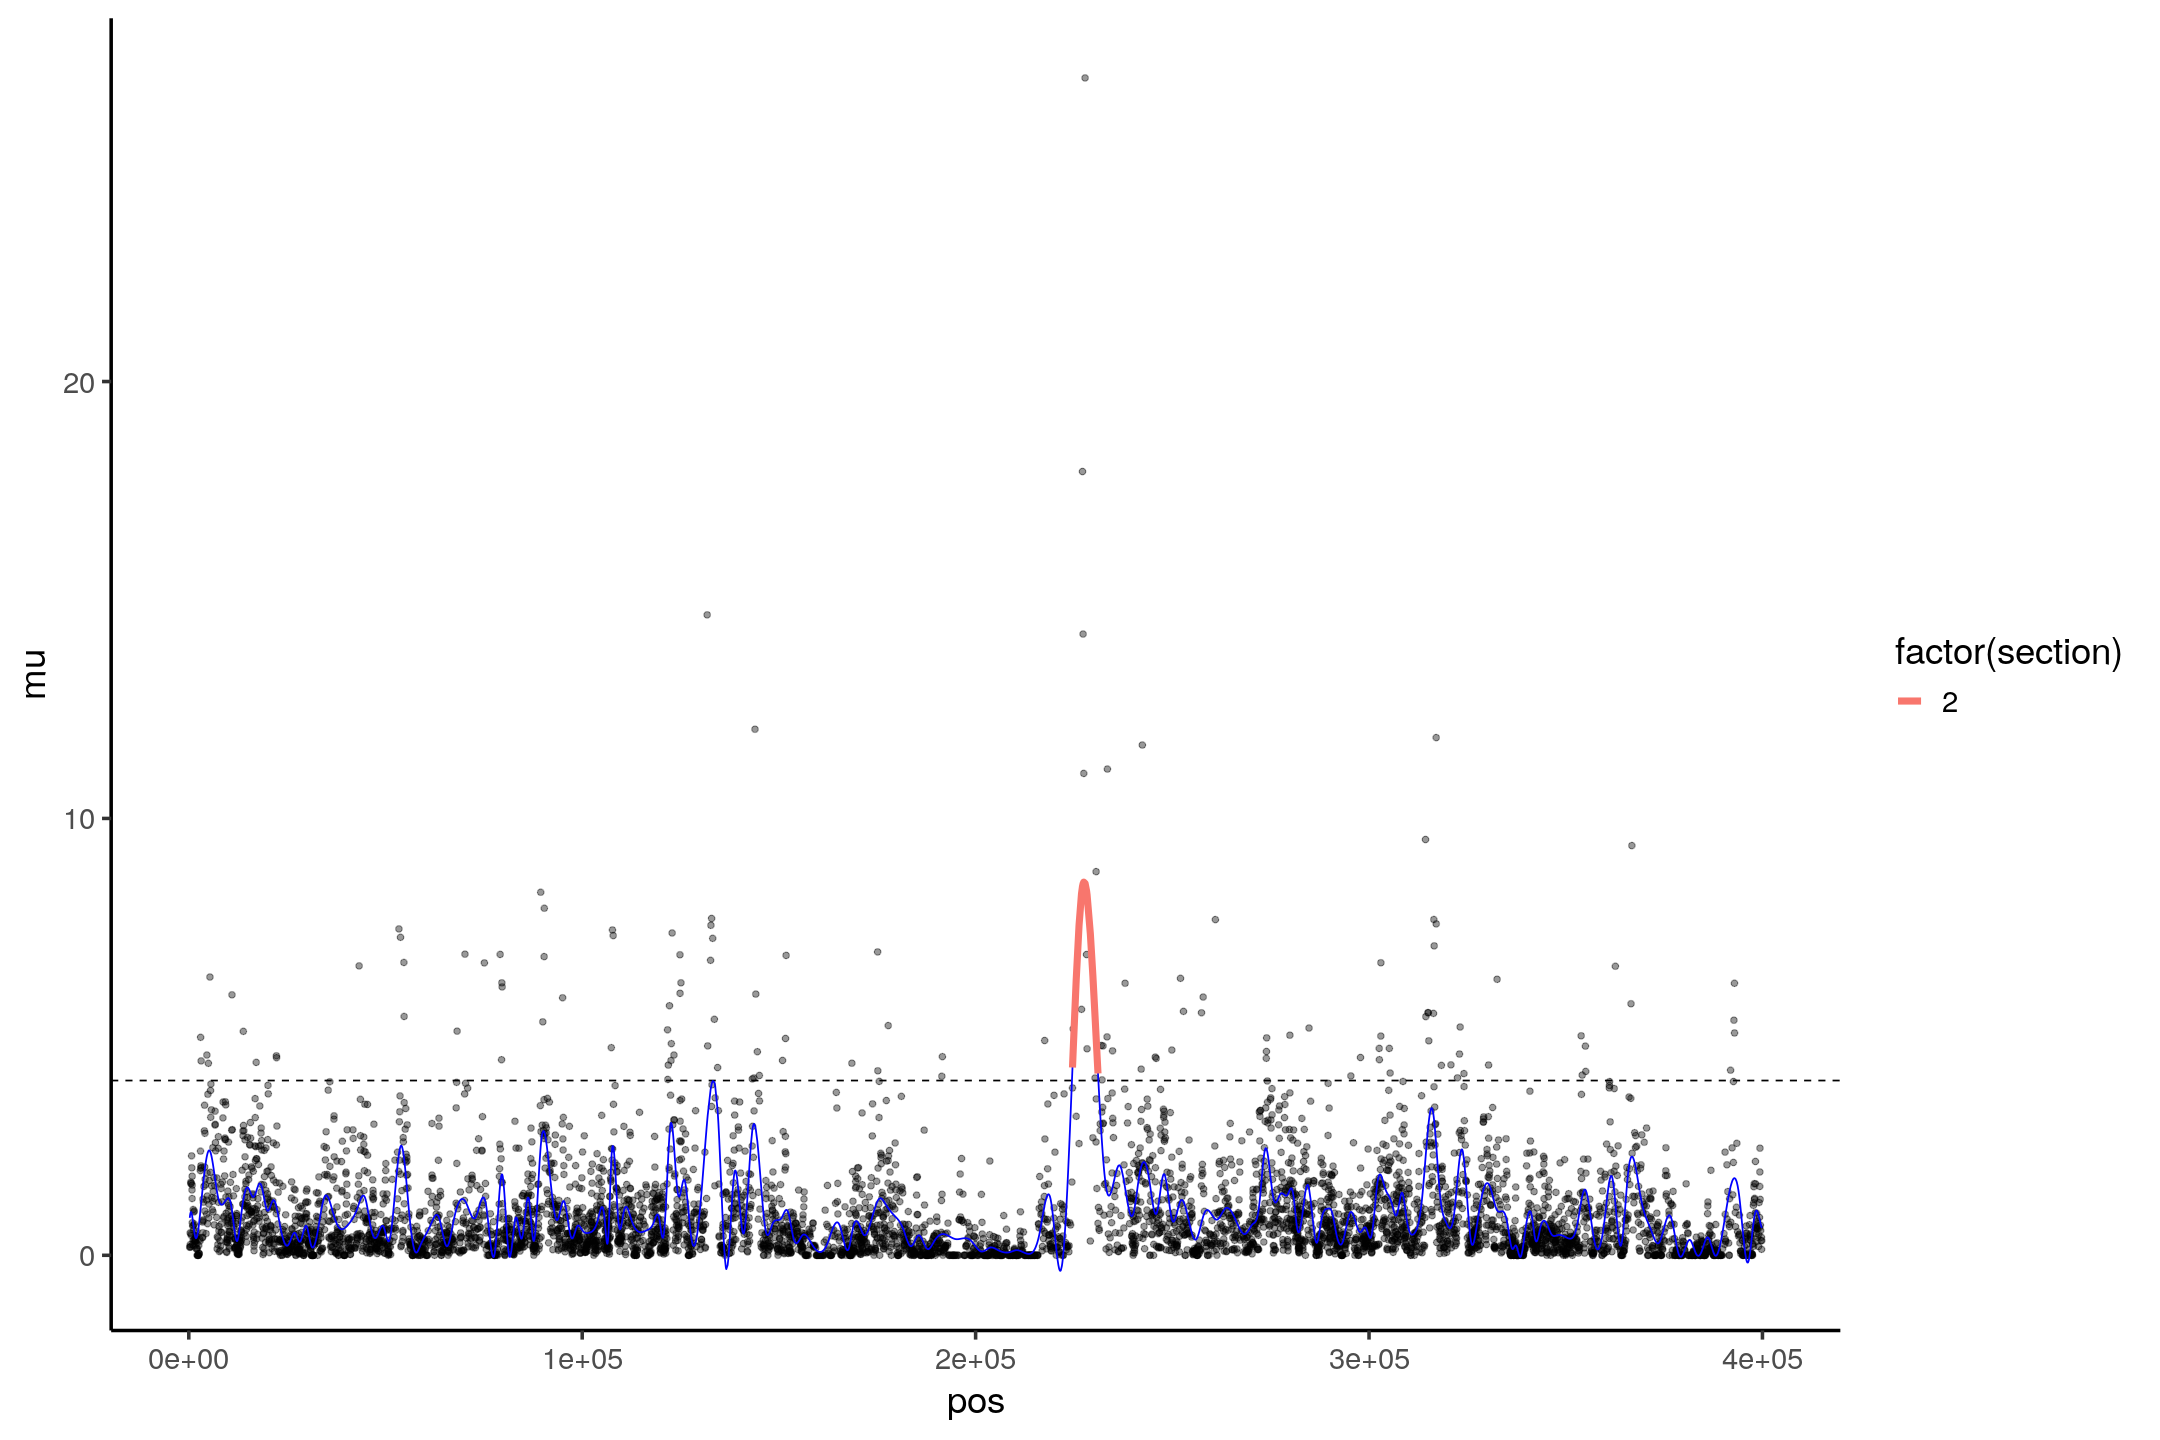

In [23]:
mu_sig <- 4
merge_size <- 1e5
sweep_pos  <- 200000
min_sweep_size <- 5e3
max_sweep_size <- 1e5
raisd_files <- fs::dir_ls("output/raisd/", glob = "*RAiSD_Report*alpha-100*")

random_file <- sample(raisd_files, 1)
print(random_file)
#random_files <- raisd_files

#read data, fit smooth spline model
rdf <- read_delim(random_file, "\t", skip = 1, col_names = c("pos", "mu"))
zz_smooth <- smooth.spline(rdf$pos, rdf$mu)
smooth_df <- bind_cols(x = zz_smooth$x, y = zz_smooth$y)

#block off outliers into sections
spline_assess <- filter(smooth_df, y > mu_sig) %>% 
    mutate(section = round(x/merge_size))

ggplot() +
    geom_point(data = filter(rdf, mu > 0), aes(pos, mu), alpha = 0.4) +
    geom_hline(yintercept = 4, lty = 2) +
    geom_line(data = smooth_df, aes(x, y), colour = "blue") +
    geom_line(data = spline_assess, aes(x, y, group = section, color = factor(section)), lwd = 2)


In [7]:
head(confusion_df)
confusion_df %>% group_by(alpha, stat_state) %>% summarise(n())

#enough false negatives for alpha > 0 -- mwar thinking!!!

section,merge_count,max_y,start,end,size,count,alpha,sweep,file,stat_state
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<fs::path>,<chr>
NA,NA,NA,-9,-9,NA,NA,0,noise,output/raisd/RAiSD_Report.rep-824_seed1-12970_seed2-47908_startfreq-0.020283240104891426_endfreq-0.999_alpha-0_sub-2,TN
2,1,4.088076,180233,180947,713,8,50,noise,output/raisd/RAiSD_Report.rep-1062_seed1-48675_seed2-59251_startfreq-0.0_endfreq-0.5_alpha-50_sub-1,TN
0,2,4.823037,38579,40487,1907,18,50,noise,output/raisd/RAiSD_Report.rep-1054_seed1-1532_seed2-59394_startfreq-0.0_endfreq-0.5_alpha-50_sub-1,TN
3,2,4.301690,290618,291566,947,10,50,noise,output/raisd/RAiSD_Report.rep-1054_seed1-1532_seed2-59394_startfreq-0.0_endfreq-0.5_alpha-50_sub-1,TN
1,2,4.033347,143728,144039,310,3,50,noise,output/raisd/RAiSD_Report.rep-2_seed1-11315_seed2-19544_startfreq-0.0_endfreq-0.999_alpha-50_sub-1,TN
2,2,4.277847,194443,197049,2605,22,50,noise,output/raisd/RAiSD_Report.rep-2_seed1-11315_seed2-19544_startfreq-0.0_endfreq-0.999_alpha-50_sub-1,TN


`summarise()` has grouped output by 'alpha'. You can override using the `.groups` argument.



alpha,stat_state,n()
<int>,<chr>,<int>
0,TN,7
10,FN,2
10,TN,1
50,FN,1
50,TN,7
50,TP,2
100,FP,1
100,TN,3
100,TP,3


In [8]:
state_df %>% filter(start < sweep_pos, end > sweep_pos)

ERROR: Error in filter(., start < sweep_pos, end > sweep_pos): object 'state_df' not found
